In [76]:
!pip install jax jaxlib
!pip install matplotlib
!pip install progress
!pip install arviz


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [77]:
import jax
from jax import grad, jit, vmap, pmap, numpy as np, random
from jax.lax import fori_loop,while_loop
import numpy as onp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import os
from progress.bar import Bar
import time
import arviz as az

# %matplotlib notebook

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/h/xla"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
os.environ["JAX_ENABLE_X64"]="1"

a = np.arange(0,10,0.001)
b = np.arange(9,-1,-0.001)
X, Y = np.meshgrid(a, b)

@jit
def func(x,y):
    return np.sin(x)+np.cos(y)

@jit
def funcl1(x,y):
    return x+y
@jit
def rastrigin(x,y):
    return 20 + x*x + y*y - 10*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))
@jit
def schwefel(x,y):
    return 418.9829*2 - x * np.sin(np.sqrt(np.abs( x ))) + y * np.sin(np.sqrt(np.abs( y )))
@jit
def f3(x,y):
    return x * np.exp(-(x*x + y*y))

def plot(func,data):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(min(data[:,0]), max(data[:,0]), 0.25)
    Y = np.arange(min(data[:,1]), max(data[:,1]), 0.25)
    X, Y = np.meshgrid(X, Y)
    Z = func(X,Y)
    # https://matplotlib.org/3.3.1/tutorials/colors/colormaps.html
    surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno,
                        linewidth=0, antialiased=True)
    scat = ax.scatter3D(data[:,0],data[:,1],data[:,2])
    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
# plot(func,np.array([[-10,10,10]]))

In [106]:
# import numpy.random as npr
# @jit
def GA(f,generations:int,scale:int,seed,shape=(100,1)):
    f = jit(f,static_argnums=(i for i in range(shape[1])))
    def pureGA(generations,scale,shape,seed):
        key = random.PRNGKey(seed)
        # key = npr.default_key()
        @jit
        def fitF(i):
            return np.array([*[j for j in list(i)[:shape[1]]],f(*[*i][:shape[1]])])
        @jit
        def fitVmap(args):
            return vmap(fitF)(args)
        def genPop(key):
            key,subkey = random.split(key)
            return key,random.normal(key,shape=shape)*scale
        genPop = jit(genPop,static_argnums=(0))
        @jit
        def sortPop(fit):
            return fit[fit[:,-1].argsort()]
        @jit
        def cross(bad,good):
            return bad*0.2+good*0.8
        @jit
        def join(p1,p2):
            return np.concatenate((p1,p2))
        @jit
        def elitism(pop):
            return sortPop(pop)[:int(shape[0])]
        @jit
        def meanifyCols(x):
            means = []
            for i in range(len(x[0])):
                means.append(np.mean(x[:,i]))
            return means
        @jit
        def loop(i,params):
            # current,key
            key, pop = genPop(params[1])        
            fitted = sortPop(fitVmap(pop))
            mated = fitVmap(cross(join(params[0],fitted),join(fitted,params[0])))
            larger = elitism(sortPop(mated))
            return [larger,params[1]]
        key, pop = genPop(key)
        current = fitVmap(pop)
        return fori_loop(0,generations,loop,[current,key])
    pureGA = jit(pureGA,static_argnums=(0,1,2,3))
    return pureGA(generations,scale,shape,seed)[0]
jGA = jit(GA,static_argnums=(0,1,2,3,4))

def GA2(f,generations:int,scale:int,seed,shape=(100,1)):
    f = jit(f,static_argnums=(i for i in range(shape[1])))
    def pureGA(generations,scale,shape,seed):
        key = random.PRNGKey(seed)
        # key = npr.default_key()
        @jit
        def fitF(i):
            return np.array([*[j for j in list(i)[:shape[1]]],f(*[*i][:shape[1]])])
        @jit
        def fitVmap(args):
            return vmap(fitF)(args)
        def genPop(key):
            key,subkey = random.split(key)
            return key,random.normal(key,shape=shape)*scale
        genPop = jit(genPop,static_argnums=(0))
        @jit
        def sortPop(fit):
            return fit[fit[:,-1].argsort()]
        @jit
        def cross(bad,good):
            return bad*0.05+good*0.95
        @jit
        def join(p1,p2):
            return np.concatenate((p1,p2))
        @jit
        def elitism(pop):
            return sortPop(pop)[:int(shape[0])]
        @jit
        def randSelect(pop):
            return jax.random.permutation(key,pop)[:int(shape[0])]
        @jit
        def meanifyCols(x):
            means = []
            for i in range(len(x[0])):
                means.append(np.mean(x[:,i]))
            return means
        @jit
        def loop(i,params):
            # current,key
            key, pop = genPop(params[1])        
            fitted = sortPop(fitVmap(pop))
            mated = fitVmap(cross(join(params[0],fitted),join(fitted,params[0])))
            larger = randSelect(sortPop(mated))
            return [larger,params[1]]
        key, pop = genPop(key)
        current = fitVmap(pop)
        return fori_loop(0,generations,loop,[current,key])
    pureGA = jit(pureGA,static_argnums=(0,1,2,3))
    return pureGA(generations,scale,shape,seed)[0]
jGA2 = jit(GA2,static_argnums=(0,1,2,3,4))

def GA3(f,generations:int,scale:int,seed,shape=(100,1)):
    f = jit(f,static_argnums=(i for i in range(shape[1])))
    def pureGA(generations,scale,shape,seed):
        key = random.PRNGKey(seed)
        # key = npr.default_key()
        @jit
        def fitF(i):
            return np.array([*[j for j in list(i)[:shape[1]]],f(*[*i][:shape[1]])])
        @jit
        def fitVmap(args):
            return vmap(fitF)(args)
        def genPop(key):
            key,subkey = random.split(key)
            return key,random.normal(key,shape=shape)*scale
        genPop = jit(genPop,static_argnums=(0))
        @jit
        def sortPop(fit):
            return fit[fit[:,-1].argsort()]
        @jit
        def cross(bad,good):
            return bad*0.05+good*0.95
        @jit
        def join(p1,p2):
            return np.concatenate((p1,p2))
        @jit
        def elitism(pop):
            return sortPop(pop)[int(shape[0]):]
        @jit
        def meanifyCols(x):
            means = []
            for i in range(len(x[0])):
                means.append(np.mean(x[:,i]))
            return means
        @jit
        def loop(i,params):
            # current,key
            key, pop = genPop(params[1])        
            fitted = sortPop(fitVmap(pop))
            mated = fitVmap(cross(join(params[0],fitted),join(fitted,params[0])))
            larger = elitism(sortPop(mated))
            return [larger,params[1]]
        key, pop = genPop(key)
        current = fitVmap(pop)
        return fori_loop(0,generations,loop,[current,key])
    pureGA = jit(pureGA,static_argnums=(0,1,2,3))
    return pureGA(generations,scale,shape,seed)[0]
jGA3 = jit(GA3,static_argnums=(0,1,2,3,4))

def MSE(result,actual):
    return np.mean((np.array(result[-1])-np.array([actual[-1] for i in range(len(result))]))**2)
def zoom(f,factor):
    return lambda x,y:func(x*factor,y*factor)

def doAndMaybePrint(f,iterations,good,to_print=True):
    opt = jGA2(f,iterations,10,666,(1000,2))
    if to_print:
        print(opt,opt.shape)
        plot(f,opt)
    return opt,MSE(opt[0],[0,0,good])

In [79]:
def goodness(func, good):
    out = []
    out.append(doAndMaybePrint(func,10,good,False)[1])
    out.append(doAndMaybePrint(func,100,good,False)[1])
    out.append(doAndMaybePrint(func,1000,good,False)[1])
    out.append(doAndMaybePrint(func,10000,good,False)[1])
    return np.array(out)
def bench(func,good):
    %timeit doAndMaybePrint(func,10,good,False)
    %timeit doAndMaybePrint(func,100,good,False)
    %timeit doAndMaybePrint(func,1000,good,False)
    %timeit doAndMaybePrint(func,10000,good,False)
    return goodness(func,good)
good = bench(func,-2)
print(good)

3.81 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.63 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.76 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.9 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
[4.462495  4.4500213 4.4829454 4.4141965]


[[-3.4441076e-02 -2.1596523e-02  3.2681012e-01]
 [ 2.6051018e-02  3.7959419e-02  4.1886044e-01]
 [-3.6518030e-02 -1.0125353e+00  1.3196461e+00]
 ...
 [ 3.9021473e+00  3.4408240e+00  4.8213985e+01]
 [ 3.6997750e+00 -2.3504870e+00  4.8219318e+01]
 [ 3.3970919e+00 -1.3696110e+00  4.8225136e+01]] (1000, 3)


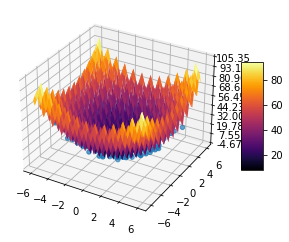

88.2 µs ± 5.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
0.106804855


In [80]:
opt = jGA(rastrigin,10000,10,666,(1000,2))
print(opt,opt.shape)
plot(rastrigin,opt)
%timeit jGA(rastrigin,10000,10,666,(1000,2))
print(MSE(opt[0],[0,0,0]))

[[-2.2313898e+01  1.9719551e+01  7.9665735e+02]
 [-1.6465349e+01  2.7146975e+01  8.0105322e+02]
 [-2.3236784e+01  1.6434477e+01  8.0186578e+02]
 ...
 [ 8.9006128e+00 -1.7902809e+00  8.3482159e+02]
 [ 8.7685785e+00 -1.6167437e+00  8.3484753e+02]
 [-7.8365093e-01 -6.2898593e+00  8.3484839e+02]] (1000, 3)


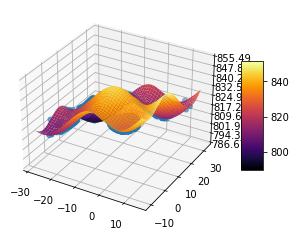

13.1 s ± 158 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.173318


In [81]:
opt = jGA(schwefel,100,10,666,(1000,2))
print(opt,opt.shape)
plot(schwefel,opt)
%timeit jGA(zoom(schwefel,100),10000,10,666,(1000,2))
print(MSE(opt[0],[-2.2e1,1.97e1,8e2]))

[[ 2.6715958e+00  2.2824461e+00  1.1602280e-05]
 [ 7.3467200e-03  2.5315850e+00  1.2097909e-05]
 [ 3.5451770e+00  5.7750203e-02  1.2298575e-05]
 ...
 [ 7.2213405e-01  3.2128591e-02  4.2824736e-01]
 [ 7.0875043e-01  2.7955232e-02  4.2854458e-01]
 [ 7.2105372e-01 -1.3449153e-02  4.2863867e-01]] (1000, 3)


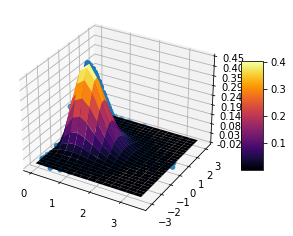

83.4 µs ± 2.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [107]:
opt = jGA3(f3,10000,10,666,(1000,2))
print(opt,opt.shape)
plot(f3,opt)
%timeit jGA3(f3,10000,10,666,(1000,2))